# 第10章: 機械翻訳
90. データの準備
91. 機械翻訳モデルの訓練
92. 機械翻訳モデルの適用
93. BLEUスコアの計測
94. ビーム探索
95. サブワード化
96. 学習過程の可視化
97. ハイパー・パラメータの調整
98. ドメイン適応
99. 翻訳サーバの構築

本章では，日本語と英語の翻訳コーパスである京都フリー翻訳タスク (KFTT)を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，fairseq，Hugging Face Transformers，OpenNMT-pyなどの既存のツールを活用せよ．

# 90. データの準備
機械翻訳のデータセットをダウンロードせよ．訓練データ，開発データ，評価データを整形し，必要に応じてトークン化などの前処理を行うこと．ただし，この段階ではトークンの単位として形態素（日本語）および単語（英語）を採用せよ．

In [22]:
from pathlib import Path

# Memo  {形態素: morpheme[mɔː(r)fiːm], 音素: phoneme[fóʊniːm]}

# 保存先ディレクトリの設定
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/10章')

# data_only_tar = data_dir / 'kftt-data-1.0.tar.gz'

# !wget -O "{data_only_tar}" https://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz

# !tar -xvzf "{data_only_tar}" -C "{data_dir}"

In [23]:
!apt install -y mecab libmecab-dev mecab-ipadic-utf8 # MeCabが正しく動作するように、システム側でもセットアップします。
!pip install mecab-python3 transformers datasets sentencepiece sacrebleu[ja] evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 62.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=cc6ef62f955c7e7b29eba55cc68f2447d5b7890944f5b360783336d00dc8fc8a
  Stored in directory: /root/.cache/pip/wheels/44/56/37/f543963822b85260c9f948df8fac8c20169c80dc71b24dc407
Successfully built ipadic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd64 0.996-14build9 [136 kB]
Get:6 http://archive.ubuntu.co

In [45]:
#データの読み込み
from io import open_code
from datasets import Dataset

# データの読み込み関数
def load_kftt_data(src_path, tgt_path): # 	一般的に、LinuxやmacOSではutf-8がデフォルトですが、Windows環境では**cp932（Shift-JIS互換）**などがデフォルトになることがあるのでencoding="utf-8"を指定したほうがプラットフォームに依存しないコードになります。
    with open(src_path, 'r', encoding="utf-8") as src_file, open(tgt_path, 'r', encoding="utf-8") as tgt_file:
        src_lines = src_file.readlines()
        tgt_lines = tgt_file.readlines()
    return Dataset.from_dict({'src': src_lines, 'tgt': tgt_lines})



In [ ]:
# kftt_dir = Path(data_dir / 'kftt-data-1.0/data/tok')
kftt_dir = Path(data_dir / 'kftt-data-1.0/data/orig')

train_data = load_kftt_data(f"{kftt_dir}/kyoto-train.ja", f"{kftt_dir}/kyoto-train.en")
dev_data = load_kftt_data(f"{kftt_dir}/kyoto-dev.ja", f"{kftt_dir}/kyoto-dev.en")
test_data = load_kftt_data(f"{kftt_dir}/kyoto-test.ja", f"{kftt_dir}/kyoto-test.en")

print(train_data[0]['src'])
print(train_data[0]['tgt'])

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [46]:
# データのトークン化処理
def preprocess_function(examples, tokenizer, max_ength=256):
    inputs = ["日本語を英語に翻訳：" + ex for ex in examples["src"]]
    targets = examples['tgt']

    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt").to(device)

    labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt").to(device)

    model_inputs['labels'] = labels['input_ids'] # labels = {'input_ids': tensor([[3, 2, 1]]), 'attention_mask': tensor([[1, 1, 1]])}
    return model_inputs

# データのトークン化 (まとめて処理)
def tokenize_data(train_data, dev_data, test_data, tokenizer):
    return (
        train_data.map(lambda x: preprocess_function(x, tokenizer), batched=True),
        dev_data.map(lambda x: preprocess_function(x, tokenizer), batched=True),
        test_data.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    )

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# モデルとトークナイザーの準備
def load_model_and_tokenizer(model_name=torch.NoneType):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    return model, tokenizer

# 91. 機械翻訳モデルの訓練
90で準備したデータを用いて，ニューラル機械翻訳のモデルを学習せよ（ニューラルネットワークのモデルはTransformerやLSTMなど適当に選んでよい）．

In [27]:
pre_trained_model, pre_trained_tokenizer = load_model_and_tokenizer(model_name="sonoisa/t5-base-japanese")   # 日本語対応T5モデル
test_tokens = pre_trained_tokenizer("雪舟", return_tensors="pt")
print(test_tokens) # {'input_ids': tensor([[3, 2, 1]]), 'attention_mask': tensor([[1, 1, 1]])}
decoded_text = pre_trained_tokenizer.decode(test_tokens["input_ids"][0], skip_special_tokens=True)
print(decoded_text) # 雪舟</s>

tokenizer_config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/804k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

{'input_ids': tensor([[   5, 1532, 5047,    1]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
雪舟


In [47]:
# fine-tuning前のsonoisa/t5-base-japaneseモデルのスコアを出しておきたい
import torch
from evaluate import load

# 推論時は日本語の文章をそのまま入力
def translate(text, model, tokenizer):
    input_text = "日本語を英語に翻訳：" + text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

    # テストデータの読み込み
# def load_test_data(src_path, tgt_path):
#     def generator():
#         with open(src_path, 'r', encoding="utf-8") as src_file, open(tgt_path, 'r', encoding="utf-8") as tgt_file:
#             for src_line, tgt_line in zip(src_file, tgt_file):
#                 yield src_line, tgt_line.strip()
#     return generator()

# from tqdm import tqdm
def load_test_data(src_path, tgt_path):
    with open(src_path, 'r', encoding="utf-8") as src_file, open(tgt_path, 'r', encoding="utf-8") as tgt_file:
        for src_line, tgt_line in zip(src_file, tgt_file):
            yield src_line, tgt_line.strip()

# ファイルの行数を取得する関数
def count_lines(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        return sum(1 for _ in f)


# テストデータに対する推論
def predict_on_test_data(model, tokenizer, src_path, tgt_path):
    predictions = []
    references = []
    total = count_lines(src_path)

    for src_sentence, tgt_sentence in tqdm(load_test_data(src_path, tgt_path), desc="Translating", total=total):
        prediction = translate(src_sentence, model, tokenizer)
        predictions.append(prediction)
        references.append(tgt_sentence)

    return predictions, references


# calculate BLEU score
def calculate_bleu(predictions, references):
    # 参照訳がリストのリスト形式かどうかを確認し、必要に応じて変換
    if isinstance(references[0], str):
        references = [[ref] for ref in references]

    metric = load("sacrebleu")
    results = metric.compute(predictions=predictions, references=references)
    return results['score']

def check_test(model, tokenizer, src_path, tgt_path):
    """
    指定されたデータセットでモデルを評価し、BLEUスコアを出力する。

    Args:
        model: 評価に使用するモデル。
        tokenizer: トークナイザー。
        src_path: 入力データのパス。
        tgt_path: 正解データのパス。
    """
    model.to(device)  # モデルをGPUに転送

    predictions, references = predict_on_test_data(model, tokenizer, src_path, tgt_path)
    bleu_score = calculate_bleu(predictions, references)
    print(f"BLEU Score: {bleu_score}")

In [48]:
# テストデータの読み込み
# def check_test(model, tokenizer):
#     kftt_dir = Path("/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-data-1.0/data/orig")
#     test_src = kftt_dir / 'kyoto-test.ja'
#     test_tgt = kftt_dir / 'kyoto-test.en'

#     # 行数を取得してtqdmにtotalを指定
#     total_lines = count_lines(test_src)

#     # テストデータを逐次翻訳
#     predictions = []
#     references = []
#     for src_sentence, tgt_sentence in tqdm(load_test_data(test_src, test_tgt), desc="Translating", total=total_lines):
#         prediction = translate(src_sentence, model, tokenizer)
#         predictions.append(prediction)
#         references.append(tgt_sentence)

#     print(f"{predictions[0]}=")
#     print(f"{references[0]}=")
#     print(f"{predictions[1]}=")
#     print(f"{references[1]}=")

#     # Fine-Tuning前のBLEUスコア計算
#     bleu_score = calculate_bleu(predictions, references)
#     print(f"BLEU Score: {bleu_score}") # 0.016658239928477907
# check_test関数の修正




In [ ]:
check_test(pre_trained_model, pre_trained_tokenizer)

In [ ]:
# # モデルの学習設定
# from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# training_args = Seq2SeqTrainingArguments(
#     output_dir=data_dir / "results",
#     evaluation_strategy="epoch",
#     logging_dir=data_dir / "logs",
#     report_to='tensorboard',  # defaultのwandbを使わずにTensorBoardを使う
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     weight_decay=0.01,
#     save_total_limit=2,
#     num_train_epochs=5,
#     predict_with_generate=True
# )

# # トークン化の実行
# tokenized_train_data, tokenized_dev_data, tokenized_test_data = tokenize_data(
#     train_data, dev_data, test_data, tokenizer
# )

# # トレーナーの作成
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_data,
#     eval_dataset=tokenized_dev_data,
#     tokenizer=tokenizer,
# )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/440288 [00:00<?, ? examples/s]

Map:   0%|          | 0/1166 [00:00<?, ? examples/s]

Map:   0%|          | 0/1160 [00:00<?, ? examples/s]

<ipython-input-12-5cf467b8740f>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# print(tokenized_train_data[0])
# decoded_text = tokenizer.decode(tokenized_train_data[0]["input_ids"], skip_special_tokens=True)
# print(decoded_text)

{'src': '雪舟（せっしゅう、1420年（応永27年）-1506年（永正3年））は号で、15世紀後半室町時代に活躍した水墨画家・禅僧で、画聖とも称えられる。\n', 'tgt': 'Known as Sesshu (1420 - 1506), he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century, and was called a master painter.\n', 'input_ids': [5, 2515, 14, 635, 26857, 36, 1532, 5047, 10, 955, 1288, 5018, 3, 152, 103, 12, 10, 21279, 323, 12, 11, 5710, 4403, 12, 10, 19093, 25, 12, 11, 11, 7, 132, 15, 3, 114, 7296, 9848, 13, 6205, 145, 9343, 3316, 9, 6439, 3308, 15, 3, 1160, 937, 350, 3558, 595, 1038, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
!tensorboard --version

2025-01-05 03:43:18.219744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 03:43:18.240182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 03:43:18.246506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 03:43:19.340890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.17.1


In [ ]:
# #  モデルの学習
# trainer.train()

# # 学習済みモデルの保存
# model.save_pretrained(data_dir/'kftt-t5-ja-en-model')
# tokenizer.save_pretrained(data_dir/'kftt-t5-ja-en-tokenizer')

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.538100,0.398549
2,0.490500,0.348886
3,0.457600,0.325027
4,0.439100,0.314761
5,0.433600,0.311600


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-t5-ja-en-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-t5-ja-en-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-t5-ja-en-tokenizer/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-t5-ja-en-tokenizer/added_tokens.json')

## トークナイザーの学習（今回はしない）

独自のデータセットに基づいてカスタムトークナイザーを学習させたい場合は、T5Tokenizerの内部で使われている**SentencePiece**を直接学習させる必要があります。

- SentencePieceは、生のテキストデータからサブワード分割を学習し、トークナイザーを生成するツールです。
- T5モデルが使うトークナイザーは、SentencePieceモデルが学習済みの状態でHugging Faceから提供されています。
  - 例1: カスタムデータセットでSentencePieceトークナイザーを学習
  - 例2: 特殊なドメイン用のカスタムトークナイザー（医療、法律など）

```
import sentencepiece as spm

# SentencePieceの学習設定
spm.SentencePieceTrainer.train(
    input='corpus.txt',  # corpus.txtという学習用の日本語のテキストデータを用意します。
    model_prefix='custom_tokenizer',  # 保存するモデルのプレフィックス
    vocab_size=32000,  # 語彙サイズ（T5は通常32k程度）
    model_type='unigram',  # モデルの種類（unigram, bpe, char, wordなど）
    character_coverage=0.9995,  # 日本語対応のため、カバー率を高く設定
    user_defined_symbols=["▁▂▃", "。", "、"]  # 必要に応じて特殊記号を追加
)
```

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {data_dir}/logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2025-01-05 22:13:33.495997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 22:13:33.516976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 22:13:33.523380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 22:13:34.656615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

# 92. 機械翻訳モデルの適用
- 91で学習したニューラル機械翻訳モデルを用い，与えられた（任意の）日本語の文を英語に翻訳するプログラムを実装せよ．

# 93.BLEUスコアの計測
- 91で学習したニューラル機械翻訳モデルの品質を調べるため，評価データにおけるBLEUスコアを測定せよ．

In [31]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# import torch


# model_dir = '/content/drive/MyDrive/Colab Notebooks/data/10章/'
# model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}/kftt-t5-ja-en-model")
# tokenizer = T5Tokenizer.from_pretrained(f"{model_dir}/kftt-t5-ja-en-tokenizer")



# ja_text = "今日はいい天気ですか？"

# translated_text = translate(ja_text, model, tokenizer)

# print(f"{ja_text=}")
# print(f"{translated_text=}")


ja_text='今日はいい天気ですか？'
translated_text='he day is good morning.'


In [49]:
from evaluate import load
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

model_dir = '/content/drive/MyDrive/Colab Notebooks/data/10章/'
trained_model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}/kftt-t5-ja-en-model")
tokenizer = T5Tokenizer.from_pretrained(f"{model_dir}/kftt-t5-ja-en-tokenizer")

kftt_dir = Path("/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-data-1.0/data/orig")
test_src = kftt_dir / 'kyoto-test.ja'
test_tgt = kftt_dir / 'kyoto-test.en'

check_test(trained_model, tokenizer, src_path=test_src, tgt_path=test_tgt) # BLEU Score: 0.016658239928477907（学習前）---> 5.5964096047522185（学習後）


Translating: 353it [08:53,  1.51s/it]


KeyboardInterrupt: 

# 94 デコード時のビーム探索

In [ ]:
from functools import lru_cache

# 翻訳関数 (ビーム探索とキャッシュを使用)
@lru_cache(maxsize=None)
def translate_with_beam_width(japanese_text, beam_width):
  input_text = "日本語を英語に翻訳：" + japanese_text
  inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)

  with torch.no_grad():
    output = model.generate(**inputs, num_beams=beam_width)

  translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
  return translated_text

Calculating BLEU scores: 100%|██████████| 4/4 [11:08<00:00, 167.25s/it]


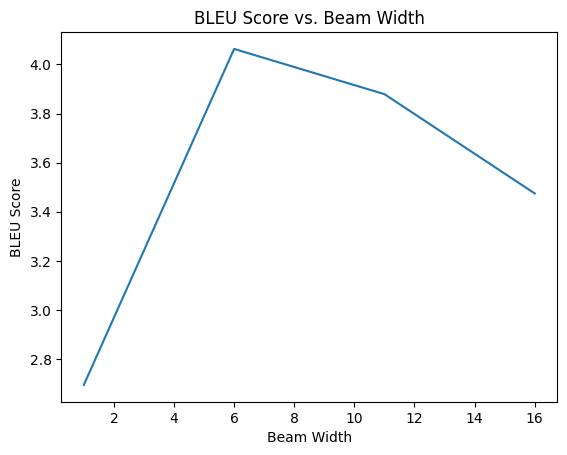

In [43]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from evaluate import load
from itertools import islice


device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

# モデルとトークナイザーの読み込み
model_dir = '/content/drive/MyDrive/Colab Notebooks/data/10章/'
model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}/kftt-t5-ja-en-model").to(device)
tokenizer = T5Tokenizer.from_pretrained(f"{model_dir}/kftt-t5-ja-en-tokenizer")



# ビーム幅の設定
beam_widths = range(1, 21, 5)  # 1から20まで5刻みでビーム幅を変化させる

# BLEUスコアの計算とプロット
bleu_scores = []
kftt_dir = Path("/content/drive/MyDrive/Colab Notebooks/data/10章/kftt-data-1.0/data/orig")
for beam_width in tqdm(beam_widths, desc="Calculating BLEU scores"):
  predictions = []
  references = []
  for src_sentence, tgt_sentence in islice(load_test_data(kftt_dir / 'kyoto-dev.ja', kftt_dir / 'kyoto-dev.en'), 100):  # 開発データの先頭100件を使用
    prediction = translate_with_beam_width(src_sentence.strip(), beam_width)
    predictions.append(prediction)
    references.append(tgt_sentence)

  bleu_score = calculate_bleu(predictions, references)
  bleu_scores.append(bleu_score)

# プロット
plt.plot(beam_widths, bleu_scores)
plt.xlabel("Beam Width")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs. Beam Width")
plt.show()